# Setup

In [1]:
import albumentations as A
import copy
import cv2
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import unittest
from albumentations.pytorch import ToTensorV2
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import nms, box_iou, box_convert
from tqdm.notebook import tqdm, trange

# YOLOv3 Architecture

In [2]:
"""
Implementation of YOLOv3 architecture
""" 
""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]
 
 
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act
 
    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)
 
 
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]
 
        self.use_residual = use_residual
        self.num_repeats = num_repeats
 
    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
 
        return x
 
 
class ScalePrediction(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, 5 * 3, bn_act=False, kernel_size=1
            ),
        )
 
    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )

#This module applies the math opperations from the YOLO paper to retrieve the true coordinates and with and height of the bboxes instead of doing this at a later stage.
class MathOperations(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.anchors = (torch.tensor(CONFIG.ANCHORS) * torch.tensor(CONFIG.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(CONFIG.DEVICE)
 
    """

    x is in the shape N x 3 x S x S x 5
    we want the last dimension to be in this order: [x, y, w, h, obj]
    In the forward we'll apply the mathematical operations described in both YOLO 9000 and YOLO V3 papers

    bx = sigma(tx) + cx
    by = sigma(ty) + cy
    bw = pw * exp(tw)
    bh = ph * exp(th)

    cx/cy = location of upper left corner of cell
    pw/ph = prior size of the anchor box
    t = vector before operation
    b = vector after operation

    """
    def forward(self, x, scale):
        # return  torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        return  torch.cat([self.sigmoid(x[..., 0:2]), torch.exp(x[..., 2:4]) * self.anchors[scale].reshape(1, 3, 1, 1, 2), self.sigmoid(x[..., 4:5])], dim=-1)
 
 
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()
 
    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        MathOperationsLayer = MathOperations()
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(MathOperationsLayer(layer(x),len(outputs)))
                continue
 
            x = layer(x)
 
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)
 
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
 
        return outputs
 
    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
 
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels
 
            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))
 
            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2),
                    ]
                    in_channels = in_channels // 2
 
                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3
 
        return layers

# Config

In [3]:
class Config:

  def __init__(self):
    self.BB_TRESHOLD = 50 #defines whats considered a large boundingbox for the filtering of the data
    self.DATA_PATH = '../wider_face/'
    self.INDEX_PATH_TRAIN = self.DATA_PATH + 'annotation/wider_face_train_bbx_gt.txt'
    self.INDEX_PATH_VAL = self.DATA_PATH + 'annotation/wider_face_val_bbx_gt.txt'
    self.IMAGE_STORE_PATH_TRAIN = self.DATA_PATH + 'train/'
    self.IMAGE_STORE_PATH_VAL = self.DATA_PATH + 'validation/'
    self.ANCHORS = [
      [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
      [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
      [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
  

    #TODO replace these by what we use
    self.DATASET = '/PASCAL_VOC'
    self.IMG_DIR = '/PASCAL_VOC/images/'
    self.LABEL_DIR = '/PASCAL_VOC/labels/'
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    # UTILS.seed_everything()  # If you want deterministic behavior
    self.NUM_WORKERS = 0 #4 causes errors on windows to have more than 0
    self.BATCH_SIZE = 10
    self.IMAGE_SIZE = 416
    self.LEARNING_RATE = 1e-4
    self.WEIGHT_DECAY = 1e-4 #staat uit nu om te overfitten, kan aan tijdens echte trainen
    self.NUM_EPOCHS = 100
    self.CONF_THRESHOLD = 0.7#0.05
    self.MAP_IOU_THRESH = 0.25#0.5
    self.NMS_IOU_THRESH = 0.25#0.45
    self.S = [self.IMAGE_SIZE // 32, self.IMAGE_SIZE // 16, self.IMAGE_SIZE // 8]
    self.PIN_MEMORY = True
    self.LOAD_MODEL = True
    self.SAVE_MODEL = True
    self.CHECKPOINT_FILE = "..\checkpoint.pth.tar"
    
    self.ANCHORS = [
        [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
        [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
        [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
    
    self.scale = 1.1
    self.train_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=int(self.IMAGE_SIZE * self.scale)),
            A.PadIfNeeded(
                min_height=int(self.IMAGE_SIZE * self.scale),
                min_width=int(self.IMAGE_SIZE * self.scale),
                border_mode=cv2.BORDER_CONSTANT,
            ),
            A.RandomCrop(width=self.IMAGE_SIZE, height=self.IMAGE_SIZE),
            A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
            A.HorizontalFlip(p=0.5),
            A.Blur(p=0.1),
            A.CLAHE(p=0.1),
            A.Posterize(p=0.1),
            A.ToGray(p=0.1),
            A.ChannelShuffle(p=0.05),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[],),
    )

    self.test_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=self.IMAGE_SIZE),
            A.PadIfNeeded(
                min_height=self.IMAGE_SIZE, min_width=self.IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
            ),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[]),
    )

CONFIG = Config()

# Utils

In [4]:
class Utils():

    def get_precision_recall(self, pred_boxes, true_boxes, iou_threshold=CONFIG.MAP_IOU_THRESH):
        """
        Video explanation of this function:
        https://youtu.be/FppOzcDvaDI
        This function calculates mean average precision (mAP)
        Parameters:
            pred_boxes (list): list of list of lists containing all bboxes with each bboxes
            specified as [cx,cy,w,h,conf_score] for each training example
            true_boxes (list): Similar as pred_boxes except all the correct ones
            iou_threshold (float): threshold where predicted bboxes is correct
        Returns:
            float: mAP value across all classes given a specific IoU threshold
        """

        # Convert list of lists of bounding boxes per sample to one list of 
        # bounding boxes with the sample as item of a bounding box.
        # This allows sorting based on confidence level
        # the shape is now [sample_idx, cx, xy, w, h, conf]
        pred_boxes = [[sample_idx] + bbox for sample_idx, sample in enumerate(pred_boxes) for bbox in sample]
        true_boxes = [[sample_idx] + bbox[:4] for sample_idx, sample in enumerate(true_boxes) for bbox in sample]

        # Tensor to keep track of already found bounding boxes.
        found = torch.zeros(len(true_boxes))

        # Sort detections based on confidence, this is the ranking for mAP
        pred_boxes.sort(key=lambda x: x[-1], reverse=True)

        # Make list of TP and FP to keep track of them for each step
        TP = torch.zeros(len(pred_boxes))
        FP = torch.zeros(len(pred_boxes))

        # Loop trough the sorted detections starting from highest confidence (rank)
        for rank, detection in enumerate(pred_boxes):

            # Find all possible ground_truths for this detection
            ground_truth = []
            ground_truth_id = []
            for id, bbox in enumerate(true_boxes):
                if bbox[0] == detection[0] and not found[id]:
                    ground_truth.append(bbox[-4:])
                    ground_truth_id.append(id)

            ground_truth = torch.tensor(ground_truth)

            # Add dimension to detection for the torchvision box_iou function
            detection = torch.Tensor(detection[1:-1]).unsqueeze(0)

            # if there is no ground truth, false positive by default
            if ground_truth.shape[0] <= 0:
                FP[rank] = 1
                continue

            IOU = UTILS.intersection_over_union(detection, ground_truth)

            best_iou = torch.max(IOU)
            best_iou_idx = torch.argmax(IOU)

            if best_iou >= iou_threshold:
                found[ground_truth_id[best_iou_idx]] = 1
                TP[rank] = 1
            else:
                FP[rank] = 1

        #comulative sum of tp and fp to be able to calculate precision and recall at each rank
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        #calculate recall and precision at each rank
        recalls = TP_cumsum / len(true_boxes) #TP / (TP + FN)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum)  #TP / TP + FP

        #add 1 to precision because before rank 0 the precision is 100%
        precisions = torch.cat((torch.tensor([1]), precisions))

        #add 0 to recalls because before rank 0 the recall is 0%
        recalls = torch.cat((torch.tensor([0]), recalls))

        return precisions, recalls


    def mean_average_precision(self, pred_boxes, true_boxes, iou_threshold=CONFIG.MAP_IOU_THRESH):

        precisions, recalls = self.get_precision_recall(pred_boxes=pred_boxes, true_boxes=true_boxes, iou_threshold=iou_threshold)
    
        #get area under precision-recall graph using trapezoid rule
        mAP = torch.trapz(precisions, recalls)
        return mAP.item()
        
        """
            This function calculates the intersection over union of two sets of
            bounding boxes. It takes the two tensors of bounding boxes and a 
            string representing their format as input. With the formats being
            defined as the following by torchvision:
            
            ‘xyxy’: boxes are represented via corners, x1, y1 being top left and 
                    x2, y2 being bottom right. This is the format that torchvision 
                    utilities expect.

            ‘xywh’: boxes are represented via corner, width and height, x1, y2 
                    being top left, w, h being width and height.

            ‘cxcywh’: boxes are represented via centre, width and height, cx, cy 
                    being center of box, w, h being width and height.
        
        """
    def intersection_over_union(self, bboxes1, bboxes2, format="cxcywh"):
        assert type(bboxes1) == torch.Tensor and type(bboxes2) == torch.Tensor, "One or both of the bboxes is not a torch.Tensor"
        bboxes1.to(CONFIG.DEVICE)
        bboxes2.to(CONFIG.DEVICE)
        
        if (format == "cxcywh"):
            return box_iou(box_convert(bboxes1,"cxcywh", "xyxy"),box_convert(bboxes2,"cxcywh", "xyxy"))
        elif (format == "xywh"):
            return box_iou(box_convert(bboxes1,"xywh", "xyxy"),box_convert(bboxes2,"xywh", "xyxy"))
        else: # format == "xyxy"
            return box_iou(bboxes1,bboxes2)


    def iou_width_height(self, boxes1, boxes2):
        """
        Parameters:
            boxes1 (tensor): width and height of the first bounding boxes
            boxes2 (tensor): width and height of the second bounding boxes
        Returns:
            tensor: Intersection over union of the corresponding boxes
        """
        intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
            boxes1[..., 1], boxes2[..., 1]
        )
        union = (
            boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
        )
        return intersection / union

    """
        This function converts a list of bboxes to the targets for each scale
        input bboxes: a list of bboxes in the form [x, y, width, height]
        returns: a list of size 3 with a target vector for each scale.
    """
    "Unit test needed"
    def bboxes_to_cellvectors(self, bboxes, anchors, S, ignore_iou_thresh):
        num_anchors = anchors.shape[0]
        num_anchors_per_scale = num_anchors // 3

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        targets = [torch.zeros((num_anchors // 3, S, S, 5)) for S in S]

        for box in bboxes:

            iou_anchors = UTILS.iou_width_height(torch.tensor(box[2:4]), anchors)  #get a list of the IOU for all anchor boxes for this bounding box
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)  #sort the list of IOU's to get the largest values first

            x, y, width, height = box
            has_anchor = [False] * 3  # each scale should have one anchor (we want to pick one anchor per scale for each bounding box)

            for anchor_idx in anchor_indices: #find an anchor that fits
                scale_idx = anchor_idx // num_anchors_per_scale #determine which scale we're working with
                anchor_on_scale = anchor_idx % num_anchors_per_scale #determines the anchor number on that scale
                s = S[scale_idx] #get the grid size
                i, j = int(s * y), int(s * x)  #determine the cell within the grid cell

                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 4] == 1 #check the objectness value for this anchor to see if its already taken by by some other bbox

                if not anchor_taken and not has_anchor[scale_idx]:

                    targets[scale_idx][anchor_on_scale, i, j, 4] = 1  #set objectness prediction target to 1 (as there is an object here)
                    x_cell, y_cell = s * x - j, s * y - i  #  determine the x and y coordinates relative to the cell, both between [0,1]

                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width, height]
                    )
                    
                    targets[scale_idx][anchor_on_scale, i, j, 0:4] = box_coordinates 

                    has_anchor[scale_idx] = True  #notify that the bbox has an anchor for this scale

                elif not anchor_taken and iou_anchors[anchor_idx] > ignore_iou_thresh: #if there is already an anchor for this bbox (so with a better iou)
                    targets[scale_idx][anchor_on_scale, i, j, 4] = -1  # set objectness of this anchor to -1 to signal to ignore prediction


        return targets


    """
        This function converts the cellvector of one scale back to a list of bounding boxes
        input cellvectors: cellvector of one scale (anchors per scale, S, S, 6))
        input anchors: a list of anchors for this scale only
        returns: a list of bounding boxes formatted as (x, y, w, h, obj_score)
    """
    "Unit test needed"
    def cellvector_to_bboxes(self, cellvector, anchors):

        cellvector = cellvector.to("cpu")

        S = cellvector.shape[2]     # get S from the size of the cellvector

        # the following code adds the index of the cell, both i and j, to the x and y positioin of the box relative to the cell. This results in the x and y relative to the image after dividing by the size of the grid
        cell_indices_x = (
            torch.arange(S)
            .repeat(3, S, 1)
        )

        cell_indices_y = cell_indices_x.permute(0, 2, 1)

        scale = 1/S
        x = scale * (cellvector[..., 0] + cell_indices_x)  # x = (cx + i) / grid_scale
        y = scale * (cellvector[..., 1] + cell_indices_y)  # y = (cy + j) / grid_scale
        w = cellvector[...,2]
        h = cellvector[...,3]
        obj_pred = cellvector[...,4]

        bboxes = torch.stack((x, y, w, h, obj_pred), dim=-1).reshape(len(anchors) * S * S, 5)

        return bboxes.tolist()

    """
        This function converts the cellvectors of all scales back to a list of bounding boxes
        input cellvectors: list with shape (#_of_scales,) of cellvectors per scale with shape (anchors per scale, S, S, 6))
        input anchors: The complete list of list of anchors
        returns: a list of bounding boxes formatted as (x, y, w, h, obj_score)
    """
    "Unit test needed"
    def cellvectors_to_bboxes(self, cellvectors, anchors):
        assert len(cellvectors) == len(anchors)

        batch_size = cellvectors[0].shape[0]

        bboxes = []
        for i in range(batch_size):
            bboxes_batch = []
            for scale_idx, cellvector in enumerate(cellvectors):
                bboxes_batch.extend(self.cellvector_to_bboxes(cellvector[i], anchors[scale_idx]))
            bboxes.append(bboxes_batch)

        return bboxes


    "Unit test needed"
    def non_max_suppression(self, bboxes, iou_threshold=CONFIG.NMS_IOU_THRESH, threshold=CONFIG.CONF_THRESHOLD, box_format="corners"):
        """
        Video explanation of this function:
        https://youtu.be/YDkjWEN8jNA
        Does Non Max Suppression given bboxes
        Parameters:
            bboxes (list): list of lists containing all bboxes with each bboxes
            specified as [x1, y1, x2, y2, obj_socre]
            iou_threshold (float): threshold where predicted bboxes is correct
            threshold (float): threshold to remove predicted bboxes (independent of IoU)
            box_format (str): "midpoint" or "corners" used to specify bboxes
        Returns:
            list: bboxes after performing NMS given a specific IoU threshold
        """
        assert type(bboxes) == list

        bboxes = [box for box in bboxes if box[4] > threshold]
        
        if len(bboxes) > 0:
            boxes = box_convert(torch.tensor([box[:4] for box in bboxes]).to(CONFIG.DEVICE),'xywh', 'xyxy')
            scores = torch.tensor([box[4] for box in bboxes]).to(CONFIG.DEVICE)

            return [bboxes[i] for i in nms(boxes, scores, iou_threshold).tolist()]
        else:
            return bboxes

    def plot_image(self, image, boxes, yolo = True):
        """Plots predicted bounding boxes on the image"""

        im = np.array(image)
        height, width, _ = im.shape

        # Create figure and axes
        fig, ax = plt.subplots(1)
        # Display the image
        ax.imshow(im)

        # box[0] is x midpoint, box[2] is width
        # box[1] is y midpoint, box[3] is height

        # Create a Rectangle patch
        for box in boxes:
            assert len(box) == 5, "box should contain x, y, width, height, obj_confidence, "
            box = box[:4]
            if yolo:
                upper_left_x = box[0] - box[2] / 2
                upper_left_y = box[1] - box[3] / 2
                rect = patches.Rectangle(
                    (upper_left_x * width, upper_left_y * height),
                    box[2] * width,
                    box[3] * height,
                    linewidth=2,
                    edgecolor="blue",
                    facecolor="none",
                )
                # Add the patch to the Axes
                ax.add_patch(rect)
            else: #coco/wider_face
                upper_left_x = box[0]
                upper_left_y = box[1]
                rect = patches.Rectangle(
                    (upper_left_x, upper_left_y),
                    box[2],
                    box[3],
                    linewidth=2,
                    edgecolor="blue",
                    facecolor="none",
                )
                # Add the patch to the Axes
                ax.add_patch(rect)

        plt.show()

    def get_evaluation_bboxes3(self, 
        loader,
        model,
        iou_threshold = CONFIG.NMS_IOU_THRESH,
        anchors = CONFIG.ANCHORS,
        threshold = CONFIG.CONF_THRESHOLD,
        box_format="midpoint",
        device="cuda",
    ):

        # Make sure model is in eval before get bboxes
        model.eval()

        all_pred_boxes = []
        all_true_boxes = []

        #go over all batches in the loader
        for (x, y) in tqdm(loader):

            #forward the entire batch trough the model to get a list of predictions for each batch
            #shape of predictions = (#_of_scales = 3,) with tensors of the form (batch_size, #_of_anchors, S, S, 5)
            x = x.to(CONFIG.DEVICE)
            with torch.no_grad():
                predictions = model(x)

            batch_size = y[0].shape[0]

            bboxes_true_batch = UTILS.cellvectors_to_bboxes(y, anchors)

            for bboxes_true in bboxes_true_batch:
                bboxes_true = UTILS.non_max_suppression(bboxes_true)
                all_true_boxes.append(bboxes_true)

            bboxes_pred_batch = UTILS.cellvectors_to_bboxes(predictions, anchors)

            for bboxes_pred in bboxes_pred_batch:
                bboxes_pred = UTILS.non_max_suppression(bboxes_pred)
                all_pred_boxes.append(bboxes_pred)

        return all_pred_boxes, all_true_boxes

    def plot_examples(self, 
        loader,
        model,
        number_of_examples = 10,
        iou_threshold = CONFIG.NMS_IOU_THRESH,
        anchors = CONFIG.ANCHORS,
        threshold = CONFIG.CONF_THRESHOLD,
        box_format="midpoint",
        device="cuda",
    ):

        assert loader.batch_size == 1

        # Make sure model is in eval before get bboxes
        model.eval()
        train_idx = 0
        all_pred_boxes = []
        all_true_boxes = []
        for batch_idx, (x, labels, true_bboxes) in enumerate(loader):

            print(true_bboxes.shape)

            image = x.squeeze().permute(1,2,0)
            x = x.to(CONFIG.DEVICE)

            with torch.no_grad():
                predictions = model(x)

            bboxes = []
            for scale_idx in range(3):
                S = predictions[scale_idx].shape[2]
                anchor = torch.tensor([*anchors[scale_idx]]).to(CONFIG.DEVICE) * S
                boxes_scale_i =self.cells_to_bboxes(
                    predictions[scale_idx], anchor, S=S, is_preds=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes += box

            nms_boxes = self.non_max_suppression(
                bboxes,
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            UTILS.plot_boxes(nms_boxes[:50], true_bboxes.squeeze(0), image)



        model.train()

    def get_mean_std(self, loader):
        # var[X] = E[X**2] - E[X]**2
        channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

        for data, _ in tqdm(loader):
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
            num_batches += 1

        mean = channels_sum / num_batches
        std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

        return mean, std


    def save_checkpoint(self, model, optimizer, filename="my_checkpoint.pth.tar"):
        print("=> Saving checkpoint")
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
        torch.save(checkpoint, filename)


    def load_checkpoint(self, checkpoint_file, model, optimizer, lr):
        print("=> Loading checkpoint")
        checkpoint = torch.load(checkpoint_file, map_location=CONFIG.DEVICE)
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])

        # If we don't do this then it will just have learning rate of old checkpoint
        # and it will lead to many hours of debugging \:
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr


    def get_loaders(self):

        train_dataset = WIDER_Dataset(
            CONFIG.INDEX_PATH_TRAIN, 
            CONFIG.IMAGE_STORE_PATH_TRAIN, 
            transform=CONFIG.test_transforms
        )

        test_dataset = WIDER_Dataset(
            CONFIG.INDEX_PATH_VAL, 
            CONFIG.IMAGE_STORE_PATH_VAL, 
            transform=CONFIG.test_transforms
        )

        train_dataset_validation = WIDER_Dataset(
            CONFIG.INDEX_PATH_TRAIN, 
            CONFIG.IMAGE_STORE_PATH_TRAIN, 
            transform=CONFIG.test_transforms,
            max_size=2,
            skip_first=2
        )
        
        train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=CONFIG.BATCH_SIZE,
            num_workers=CONFIG.NUM_WORKERS,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=True,
            drop_last=False,
        )

        test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=CONFIG.BATCH_SIZE,
            num_workers=CONFIG.NUM_WORKERS,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=False,
            drop_last=False,
        )

        train_loader_validation = DataLoader(
            dataset=train_dataset_validation,
            batch_size=2,
            num_workers=0,
            pin_memory=CONFIG.PIN_MEMORY,
            shuffle=False,
            drop_last=False,
        )

        return train_loader, test_loader, train_loader_validation

    def plot_couple_examples(self, model, loader, thresh, iou_thresh, anchors):
        model.eval()
        x, y = next(iter(loader))
        x = x.to("cuda")
        with torch.no_grad():
            out = model(x)
            bboxes = [[] for _ in range(x.shape[0])]
            for i in range(3):
                batch_size, A, S, _, _ = out[i].shape
                anchor = anchors[i]
                boxes_scale_i = cells_to_bboxes(
                    out[i], anchor, S=S, is_preds=True
                )
                for idx, (box) in enumerate(boxes_scale_i):
                    bboxes[idx] += box

            model.train()

        for i in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
            )
            self.plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)

    def evaluate_model(self, test_loader, model):

        model.eval()

        pred_boxes, true_boxes = UTILS.get_evaluation_bboxes3(
                        test_loader,
                        model
                    )
        
        mAP = UTILS.mean_average_precision(true_boxes=true_boxes, pred_boxes=pred_boxes)

        
        # class_accuracy, no_obj_accuracy, obj_accuracy = UTILS.check_class_accuracy(model, test_loader, threshold=CONFIG.CONF_THRESHOLD)

        return mAP#, class_accuracy, no_obj_accuracy, obj_accuracy

    def seed_everything(self, seed=42):
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 

UTILS = Utils()

import unittest
import math

class test_bboxes_to_cellvectors(unittest.TestCase):

    def itterateEqual (self, expectedOutcome, cellVectors):
        #print(expectedOutcome[0].shape)
        for l in range(3): 
            for bb in range(self.num_anchors//3):
                for s1 in range(self.S[l]):
                    for s2 in range(self.S[l]):
                        for j in range(5):
                            #Should result in a faulty test? It might return a 0 vector because non of the bb have a good enough matching iou? 
                                        #See how the bboxes are defined/calculated (in Widerfaces_dataset).
                            self.assertEqual(expectedOutcome[l][bb][s1][s2][j], cellVectors[l][bb][s1][s2][j])
                            

    def setUp(self):
        self.anchors = torch.tensor(CONFIG.ANCHORS[0] + CONFIG.ANCHORS[1] + CONFIG.ANCHORS[2])
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.S = CONFIG.S

    def test_single_box(self):
        #test a single box in the middle of a image:
        x, y, w, h = 0.5, 0.5, 0.1, 0.1
        bboxes = [[x, y, w, h]] #list of bb that have to be converted

        cellVectors = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, CONFIG.S, 0.5) #result from function
        
        #expected result:
        expectedOutcome = [torch.zeros((self.num_anchors // 3, S, S, 5)) for S in self.S] 
        #note that the cellvectors have their width and height relative to the image size, not relative to the bboxes.
        expectedOutcome[0][0][6][6] = torch.tensor([0.5, 0.5, 0.1, 0.1, 1]) #add bbox to the first layer
        expectedOutcome[1][0][13][13] = torch.tensor([0, 0, 0, 0, -1]) #add ignore flag to the second layer (cause there are two well matchin bboxes on this layer)
        expectedOutcome[1][1][13][13] = torch.tensor([0, 0, 0.1, 0.1, 1]) #add bbox to the second layer (this is the one witht he highest IOU)
        expectedOutcome[2][2][26][26] = torch.tensor([0, 0, 0.1, 0.1, 1]) #add bbox to the third layer (this one has a low IOU of 0.48 but should still be added as it is the highest)

        self.itterateEqual (expectedOutcome, cellVectors)

    def test_overlapping_boxes(self): #tests what happens when boxes overlap
        ### overlap, but equal shape ###
        x, y, w, h = 0.5, 0.5, 0.1, 0.1
        bboxes = [[x, y, w, h], [x+0.01, y+0.01, w, h]] #list of bb that have to be converted

        cellVectors = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, CONFIG.S, 0.5) #result from function

        #expected result:
        expectedOutcome = [torch.zeros((self.num_anchors // 3, S, S, 5)) for S in self.S] 
        #note that the cellvectors have their width and height relative to the image size, not relative to the bboxes.
        #make changes for the first bbox
        expectedOutcome[0][0][6][6] = torch.tensor([0.5, 0.5, 0.1, 0.1, 1]) #add bbox to the first layer
        expectedOutcome[1][0][13][13] = torch.tensor([0, 0, 0, 0, -1]) #add ignore flag to the second layer (cause there are two well matchin bboxes on this layer)
        expectedOutcome[1][1][13][13] = torch.tensor([0, 0, 0.1, 0.1, 1]) #add bbox to the second layer (this is the one witht he highest IOU)
        expectedOutcome[2][2][26][26] = torch.tensor([0, 0, 0.1, 0.1, 1]) #add bbox to the third layer (this one has a low IOU of 0.48 but should still be added as it is the highest)
        #make changes for the second bbox:
        expectedOutcome[0][1][6][6] = torch.tensor([0.63, 0.63, 0.1, 0.1, 1])
        expectedOutcome[1][0][13][13] = torch.tensor([0.26, 0.26, 0.1, 0.1, 1]) #the second box should override the 'ignore' flag of the first box
        expectedOutcome[2][1][26][26] = torch.tensor([0.52, 0.52, 0.1, 0.1, 1])

        self.itterateEqual (expectedOutcome, cellVectors)

        ### overlap non-equal shape ###
        x, y, w, h = 0.5, 0.5, 0.1, 0.1
        bboxes = [[x, y, w, h], [x+0.01, y+0.01, w+0.01, h+0.01]] #list of bb that have to be converted

        cellVectors = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, CONFIG.S, 0.5) #result from function

        #expected result:
        expectedOutcome = [torch.zeros((self.num_anchors // 3, S, S, 5)) for S in self.S] 
        #note that the cellvectors have their width and height relative to the image size, not relative to the bboxes.
        #make changes for the first bbox
        expectedOutcome[0][0][6][6] = torch.tensor([0.5, 0.5, 0.1, 0.1, 1]) #add bbox to the first layer
        expectedOutcome[1][0][13][13] = torch.tensor([0, 0, 0, 0, -1]) #add ignore flag to the second layer (cause there are two well matchin bboxes on this layer)
        expectedOutcome[1][1][13][13] = torch.tensor([0, 0, 0.1, 0.1, 1]) #add bbox to the second layer (this is the one witht he highest IOU)
        expectedOutcome[2][2][26][26] = torch.tensor([0, 0, 0.1, 0.1, 1]) #add bbox to the third layer (this one has a low IOU of 0.48 but should still be added as it is the highest)
        #make changes for the second bbox:
        expectedOutcome[0][1][6][6] = torch.tensor([0.63, 0.63, 0.11, 0.11, 1]) #This box should get priority for bb number 0 since the biger size gives it a higher iou, but it does not atm. Is this a problem?
        expectedOutcome[1][0][13][13] = torch.tensor([0.26, 0.26, 0.11, 0.11, 1]) #the second box should override the 'ignore' flag of the first box
        expectedOutcome[2][1][26][26] = torch.tensor([0.52, 0.52, 0.11, 0.11, 1])

        self.itterateEqual (expectedOutcome, cellVectors)
    
    def test_bboxNearSides(self):
        ### place the bbox near the sides so that it spills over ###
        x, y, w, h = 0.95, 0.95, 0.1, 0.1
        bboxes = [[x, y, w, h]] #list of bb that have to be converted

        cellVectors = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, CONFIG.S, 0.5) #result from function

        #expected result:
        expectedOutcome = [torch.zeros((self.num_anchors // 3, S, S, 5)) for S in self.S] 
        #note that the cellvectors have their width and height relative to the image size, not relative to the bboxes.
        #make changes for the first bbox
        expectedOutcome[0][0][12][12] = torch.tensor([0.35, 0.35, 0.1, 0.1, 1]) #add bbox to the first layer
        expectedOutcome[1][0][24][24] = torch.tensor([0, 0, 0, 0, -1]) #add ignore flag to the second layer (cause there are two well matchin bboxes on this layer)
        expectedOutcome[1][1][24][24] = torch.tensor([0.7, 0.7, 0.1, 0.1, 1]) #add bbox to the second layer (this is the one witht he highest IOU)
        expectedOutcome[2][2][49][49] = torch.tensor([0.4, 0.4, 0.1, 0.1, 1]) #add bbox to the third layer (this one has a low IOU of 0.48 but should still be added as it is the highest)

        self.itterateEqual (expectedOutcome, cellVectors)

class test_non_max_supressions(unittest.TestCase):

    def test_SingleBbLowConfidence(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.5]]
        outcome = UTILS.non_max_suppression(bboxes)
        self.assertEqual(outcome, [])

    def test_SingleBbHighConfidence(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.8]]
        outcome = UTILS.non_max_suppression(bboxes)
        self.assertEqual(outcome, bboxes)

    def test_overlappingLowIou(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.8], [0.58, 0.5, 0.1, 0.1, 0.8]]
        outcome = UTILS.non_max_suppression(bboxes)

        #make sure both lists are in the same order before running test
        bboxes.sort()
        outcome.sort()

        self.assertEqual(outcome, bboxes)

    def test_overlappingHighIou(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.8], [0.56, 0.5, 0.1, 0.1, 0.9]]
        outcome = UTILS.non_max_suppression(bboxes)

        self.assertEqual(outcome, [[0.56, 0.5, 0.1, 0.1, 0.9]])

    def test_overlappingMixedIou(self):
        #[x1, y1, x2, y2, obj_socre]
        bboxes = [[0.5, 0.5, 0.1, 0.1, 0.8], [0.64, 0.5, 0.1, 0.1, 0.8], [0.56, 0.5, 0.1, 0.1, 0.9]]
        outcome = UTILS.non_max_suppression(bboxes)

        #make sure both lists are in the same order before running test
        expectedOutcome = [[0.64, 0.5, 0.1, 0.1, 0.8], [0.56, 0.5, 0.1, 0.1, 0.9]]
        expectedOutcome.sort()
        outcome.sort()

        self.assertEqual(outcome, expectedOutcome)


class TestMAP(unittest.TestCase):

    def setUp(self):
        self.margin = 1e-5
        

    def test_false_positive_simple(self):
        predictions = [
            [
                [0.5, 0.5, 0.2, 0.2, 1]
            ]
        ]

        target = [
            [
                [0.9, 0.9, 0.01, 0.01]
            ]
        ]

        score = UTILS.mean_average_precision(pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)
        manual_score = 0

        self.assertTrue(abs(score - manual_score) < self.margin)



    def test_true_positive_simple(self):
        predictions = [
            [
                [0.5, 0.5, 0.2, 0.2, 1]
            ]
        ]

        target = [
            [
                [0.5, 0.5, 0.2, 0.2]
            ]
        ]

        score = UTILS.mean_average_precision(pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)
        manual_score = 1

        self.assertTrue(abs(score - manual_score) < self.margin)


    def test_single_sample_complex(self):
        predictions = [
            [
                [0.5, 0.5, 0.2, 0.2, 1],
                [0.9, 0.9, 0.01, 0.01, 0],
                [0.1, 0.1, 0.1, 0.1, 0.5]
            ]
        ]

        target = [
            [
                [0.1, 0.1, 0.01, 0.01, 1],
                [0.5, 0.5, 0.2, 0.2, 1],
                [0.9, 0.9, 0.01, 0.0099, 1]
            ]
        ]

        score = UTILS.mean_average_precision(pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)

        manual_score = (1 + 0.75) / 2 * 1/3 + (0.75 + 0.6667) / 2 * 1/3

        self.assertTrue(abs(score - manual_score) < self.margin)

    def test_false_positive_multiple_simple(self):
        predictions = [
            [

            ],
            [
                [0.5, 0.5, 0.2, 0.2, 1]
            ]
        ]

        target = [
            [
                [0.5, 0.5, 0.2, 0.2]
            ],
            [

            ]
        ]

        score = UTILS.mean_average_precision(pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)

        manual_score = 0

        self.assertTrue(abs(score - manual_score) < self.margin)


    def test_multiple_complex(self):
        predictions = [
            [
                [0.5, 0.5, 0.2, 0.2, 0.9],
                [0.5, 0.5, 0.2, 0.2, 0.8],
                [0.9, 0.9, 0.001, 0.001, 0.7]
            ],
            [
                [0.5, 0.5, 0.2, 0.2, 1]
            ]
        ]

        target = [
            [
                [0.5, 0.5, 0.2, 0.2]
            ],
            [
                [0.9, 0.9, 0.01, 0.01]
            ]
        ]

        score = UTILS.mean_average_precision(pred_boxes=predictions, true_boxes=target, iou_threshold=0.5)

        manual_score = (0 + 0.5)/2 * 0.5

        self.assertTrue(abs(score - manual_score) < self.margin)

unittest.main(argv=['first-arg-is-ignored'], exit=False)

.............
----------------------------------------------------------------------
Ran 13 tests in 5.057s

OK


# Dataset

torch.Size([1, 3, 13, 13, 5])
tensor([0.4500, 0.7655, 0.0882, 0.1076, 1.0000])


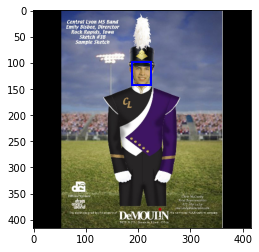

In [5]:
"""
Creates a Pytorch dataset to load the WIDER face dataset
"""
ImageFile.LOAD_TRUNCATED_IMAGES = True

def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)


"""
This function returns a dictionary containing all training samples, for each sample containing the image location ("file_name") and defention of the bounding boxes ("bounding_boxes")
returns: the above discribed dict
"""
def read_data_index(index_path, skip_big_bb = False):
  training_set = []

  f = open(index_path, "r")
  while True:
    file_name = f.readline().strip()

    if not file_name: break

    incl = True #A boolean that tracks whether an image includes ANY large faces, if this bool is set to false the whole image will be skipped
                        # (in the case that skip_big_bb = True)
    boxes = []
    isSmall = []
    box_count = int(f.readline())
    if box_count >= 1:
      for i in range(box_count):
        box = f.readline().strip().split(' ')

        treshold = CONFIG.BB_TRESHOLD 
        if int(box[2]) < treshold:
            box = tuple([int(x) for x in box])
            boxes.append(box)
        elif not skip_big_bb:
            box = tuple([int(x) for x in box]) 
            boxes.append(box)
        else:
            incl = False
        
    else:
        next(f)

    if incl:
        instance = {
            "file_name": file_name,
            "bounding_boxes": boxes
            }

        training_set.append(instance)
        # print("new instance: " + str(instance))

  return training_set


class WIDER_Dataset(Dataset):
    def __init__(
        self,
        index_path,
        image_store_path,
        transform=None,
        max_size=None,
        skip_first=0,
        anchors=CONFIG.ANCHORS,
        image_size=CONFIG.IMAGE_SIZE,
        S=CONFIG.S
    ):
        self.index_path = index_path
        self.image_store_path = image_store_path
        self.data_index = read_data_index(index_path)
        self.max_size = max_size
        self.skip_first = skip_first
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.ignore_iou_thresh = 0.5
        self.DEFAULT_FACE_CLASS = 1

    def __len__(self):
        return (len(self.data_index) - self.skip_first if not self.max_size else self.max_size)

    def __getitem__(self, index):

        index = index + self.skip_first

        index_item = self.data_index[index]
        bboxes = index_item.get('bounding_boxes')
        img_path = self.image_store_path + index_item.get('file_name')

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        image2 = np.array(Image.open(img_path).convert("RGB"))
        
        # [left, top, width, height, score]
        bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] if bbox[2] > 0 and bbox[3] > 0 else
                [bbox[0],bbox[1],bbox[2],1] if bbox[2] > 0 else 
                [bbox[0],bbox[1],1,bbox[3]] if bbox[3] > 0 else
                [bbox[0],bbox[1],1,1] for bbox in bboxes]
        
        # bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] for bbox in bboxes if bbox[2] > 0 and bbox[3] > 0]
        try:
            if self.transform:
                augmentations = self.transform(image=image, bboxes=bboxes)
                image = augmentations["image"]
                bboxes = augmentations["bboxes"]
        except:
            for box in bboxes:
                try:
                    augmentations = self.transform(image=image2, bboxes=[box])
                except Exception as error:
                    print(img_path)
                    print(box)
                    print(error)
                    
        # convert from WIDER X (left) Y (top) width height (absolute) to YOLO X (centre) Y (centre) Width Height (with respect to the image)
        image_width = image.shape[1]
        image_height = image.shape[2]
        
        bboxes = [[max(0,min((bbox[0] + 0.5 * bbox[2] - 1) / image_width,1)), 
                    max(0,min((bbox[1] + 0.5 * bbox[3] - 1) / image_height,1)),
                    min(bbox[2] / image_width,1),
                    min(bbox[3] / image_height,1)] 
                    for bbox in bboxes]        
        
        targets = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, self.S, self.ignore_iou_thresh)

        return image, targets#, torch.Tensor(bboxes)
        # return image, bboxes

class WIDER_Dataset_Filter_BB(Dataset):
    def __init__(
        self,
        index_path,
        image_store_path,
        transform=None,
        max_size=None,
        anchors=CONFIG.ANCHORS,
        image_size=CONFIG.IMAGE_SIZE,
        S=CONFIG.S
    ):
        self.index_path = index_path
        self.image_store_path = image_store_path
        self.data_index = read_data_index(index_path, True)
        self.max_size = max_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.ignore_iou_thresh = 0.5
        self.DEFAULT_FACE_CLASS = 1

    def __len__(self):
        return (len(self.data_index) if not self.max_size else self.max_size)

    def __getitem__(self, index):

        index_item = self.data_index[index]
        bboxes = index_item.get('bounding_boxes')
        img_path = self.image_store_path + index_item.get('file_name')

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] if bbox[2] > 0 and bbox[3] > 0 else 
                [bbox[0],bbox[1],bbox[2],1] if bbox[2] > 0 else 
                [bbox[0],bbox[1],1,1] for bbox in bboxes]

        # bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] for bbox in bboxes if bbox[2] > 0 and bbox[3] > 0]

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]
        
        image_width = image.shape[1]
        image_height = image.shape[2]

        # convert from WIDER X (left) Y (top) width height (absolute) to YOLO X (centre) Y (centre) Width Height (with respect to the image)
        bboxes = [
                    [max(0,min((bbox[0] + 0.5 * bbox[2] - 1) / image_width,1)), 
                    max(0,min((bbox[1] + 0.5 * bbox[3] - 1) / image_height,1)),
                    min(bbox[2] / image_width,1),
                    min(bbox[3] / image_height,1)] 
                  for bbox in bboxes]
        
        targets = UTILS.bboxes_to_cellvectors(bboxes, self.anchors, self.S, self.ignore_iou_thresh)

        return image, targets#, torch.Tensor(bboxes)
        # return image, bboxes
 

def test():
    anchors = CONFIG.ANCHORS
 
    transform = CONFIG.test_transforms
 
    dataset = WIDER_Dataset(
          CONFIG.INDEX_PATH_TRAIN, 
          CONFIG.IMAGE_STORE_PATH_TRAIN, 
          transform=transform
      )

    loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)
    for x, y in loader:
        print(np.shape(y[0]))
        
        for vector in y[0][0].view(3*13*13, 5):
            if vector[4] != 0:
                print(vector)

        bboxes_batch = UTILS.cellvectors_to_bboxes(y, anchors)

        bboxes = UTILS.non_max_suppression(bboxes_batch[0], iou_threshold=1, threshold=0.7)

        # print(bboxes)

        UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

        break

test()

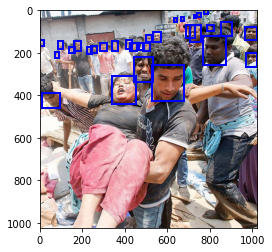

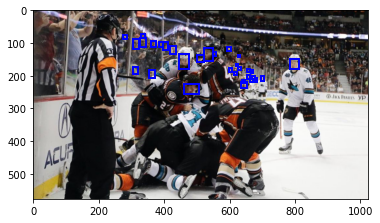

In [6]:
bboxes = [[528,256,153,169,1],
        [341,309,110,131,1],
        [444,220,88,118,1],
        [163,145,32,45,1],
        [284,155,33,36,1],
        [770,122,109,136,1],
        [966,77,55,64,1],
        [969,198,55,70,1],
        [338,144,29,45,1],
        [427,151,29,39,1],
        [407,139,28,41,1],
        [222,170,22,34,1],
        [240,167,31,33,1],
        [0,138,18,30,2],
        [86,146,24,35,1],
        [138,172,26,27,1],
        [487,155,32,35,1],
        [468,153,21,34,1],
        [499,117,28,32,2],
        [535,101,35,47,1],
        [708,69,53,78,1],
        [687,69,44,59,1],
        [788,69,31,30,2],
        [633,35,15,21,2],
        [663,31,14,18,2],
        [724,22,12,13,2],
        [741,14,16,15,2],
        [1050,142,0,50,2], #not visible and x bigger than image size (1024)
        [771,0,19,15,2],
        [70,195,22,30,2],
        [852,52,52,68,1],
        [10,388,87,71,1]]

img_path = "../wider_face/train/54--Rescue/54_Rescue_rescuepeople_54_29.jpg"
image = np.array(Image.open(img_path).convert("RGB"))
UTILS.plot_image(image, bboxes,yolo=False)

bboxes = [[784, 148, 27, 33, 2], 
        [696, 202, 10, 13, 2], 
        [304, 88, 20, 29, 2], 
        [352, 183, 20, 25, 2], 
        [445, 134, 32, 46, 1], 
        [460, 224, 45, 33, 1], 
        [395, 97, 16, 25, 2], 
        [1026, 474, 0, 23, 2], #not visible and x bigger than image size (1024)
        [384, 97, 11, 15, 2], 
        [521, 114, 27, 40, 2], 
        [499, 137, 21, 22, 2], 
        [325, 86, 18, 25, 2], 
        [303, 173, 17, 22, 2], 
        [274, 74, 13, 13, 2], 
        [329, 72, 13, 13, 2], 
        [652, 198, 10, 11, 2], 
        [661, 210, 10, 9, 2], 
        [676, 206, 9, 13, 2], 
        [668, 201, 8, 10, 2], 
        [599, 177, 9, 12, 2], 
        [627, 173, 9, 11, 2], 
        [626, 137, 5, 7, 2], 
        [619, 164, 5, 6, 2], 
        [639, 212, 7, 9, 2], 
        [418, 108, 19, 25, 2], 
        [359, 94, 16, 17, 2], 
        [612, 188, 10, 11, 2], 
        [653, 178, 10, 11, 2], 
        [634, 220, 20, 17, 2], 
        [550, 127, 9, 12, 2], 
        [593, 112, 12, 13, 2], 
        [665, 182, 6, 11, 2]]

img_path = "../wider_face/validation/39--Ice_Skating/39_Ice_Skating_iceskiing_39_583.jpg"
image = np.array(Image.open(img_path).convert("RGB"))
UTILS.plot_image(image, bboxes,yolo=False)

# Loss function

In [23]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""

class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        # self.bce = nn.BCEWithLogitsLoss()
        self.bce = nn.BCELoss()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

        # self.lambda_noobj = 15
        # self.lambda_obj = 2
        # self.lambda_box = 35

    def weighted_mse_loss(self, input, target, weight):
        return torch.sum(weight * (input - target) ** 2)

    def obj_present(self, target):
        return target[..., 4] == 1

    def get_box_predictions(self, bbox_list):
        return bbox_list[...,0:4]

    def get_obj_predictions(self, bbox_list):
        return bbox_list[...,4]

    def get_no_object_loss(self, target, prediction, obj_present):

        obj_not_present = torch.logical_not(obj_present)

        target_object_score = self.get_obj_predictions(target[obj_not_present])
        prediction_object_score = self.get_obj_predictions(prediction[obj_not_present])

        return self.bce(prediction_object_score, target_object_score)

    def get_object_loss_simplified(self, target, prediction, object_present):

        target_object_score = self.get_obj_predictions(target[object_present])
        prediction_oject_score = self.get_obj_predictions(prediction[object_present])

        object_loss = self.bce(prediction_oject_score, target_object_score)
        return object_loss

    def get_object_loss(self, target, prediction, object_present):

        #take the scale for later
        scale = 1 / target.shape[2]
        
        #select only the boxes of interest (where there are supposed to be boxes)
        target = target[object_present]
        prediction = prediction[object_present]
        
        #scale the x and y position according to the scale to be able to calculate IOU (no need to add the actual grid position here because for the IOU only the relative distance is important)
        #rescaling is needed because in the output vector of the model x and y are relative to the grid cell, while with and height are relative to the hole image. These have to be in the same shape to be able to calculate IOU
        target[...,0:2] = target[...,0:2] * scale
        prediction[...,0:2] = prediction[...,0:2] * scale

        target_object_score = self.get_obj_predictions(target)
        prediction_oject_score = self.get_obj_predictions(prediction)

        #calculate the IOU of the boxes 
        ious = UTILS.intersection_over_union(self.get_box_predictions(target), self.get_box_predictions(prediction.detach()))
        ious = torch.diagonal(ious)
        
        #if there is an object, the object score should be equal to the IOU of the predicting box and the true box
        object_loss = self.bce(prediction_oject_score, ious * target_object_score)

        return object_loss

        # return self.bce(target_object_score, prediction_oject_score)
        # return self.mse(target_object_score, prediction_object_score)

    def get_box_loss(self, target, prediction, object_present):
        target_box = self.get_box_predictions(target[object_present])
        predicted_box = self.get_box_predictions(prediction[object_present])

        target_box[...,2:4] = torch.log(1e-16 + target_box[...,2:4])
        predicted_box[...,2:4] = torch.log(1e-16 + predicted_box[...,2:4])

        return self.mse(predicted_box, target_box)


    def forward(self, predictions, target):
        # FORMAT: (x, y, w, h, obj)

        object_present = self.obj_present(target)

        return (
            self.lambda_box * self.get_box_loss(target, predictions, object_present)
            + self.lambda_obj * self.get_object_loss(target, predictions, object_present)
            # + self.lambda_obj * self.get_object_loss_simplified(target, predictions, object_present)
            + self.lambda_noobj * self.get_no_object_loss(target, predictions, object_present)
        )

"""
This is the implementation of our custom desined loss function 
"""
class RescaledPositionalLoss(YoloLoss):

    def __init__(self):
        super().__init__()
        self.lambda_pos = 0.01
        self.lambda_size = 1
        
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 5

    def get_box_loss(self, target, prediction, object_present):
        target_box = self.get_box_predictions(target[object_present])
        predicted_box = self.get_box_predictions(prediction[object_present])

        #the weights are equal to the reciproke of the dimensions of the box (linear)
        weights = 1/target_box[...,2:4].detach()

        target_box[...,2:4] = torch.log(1e-16 + target_box[...,2:4])
        predicted_box[...,2:4] = torch.log(1e-16 + predicted_box[...,2:4])

        size_loss = self.mse(predicted_box[...,2:4], target_box[...,2:4])

        position_loss_x =  self.weighted_mse_loss(predicted_box[...,0], target_box[...,0], weights[...,0])
        position_loss_y =  self.weighted_mse_loss(predicted_box[...,1], target_box[...,1], weights[...,1])

        return self.lambda_pos * (position_loss_x + position_loss_y) + self.lambda_size * size_loss

In [24]:
import unittest
import math

class TestLossFunction(unittest.TestCase):
    
    def generate_empty_example(self):
        batch_size = 1
        S = 3
        anchors_per_scale = 3

        target = torch.zeros(batch_size, anchors_per_scale, S, S, 5)
        predictions = torch.zeros(batch_size, anchors_per_scale, S, S, 5)

        return target, predictions

    def setUp(self):
        self.lossfn = YoloLoss()
        self.rescaledpositionallossfn = RescaledPositionalLoss()


    def test_no_object_loss(self):
        target, predictions = self.generate_empty_example()

        #correct object score, loss = 0
        target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])

        #incorrect object score, but should be ignored because there is an object loss = 0
        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0.5])

         #wrong_box_score, loss = -1 * (yn log(xn) + (1-yn)log(1-xn)) = 
        target[0,0,1,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,1,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0.5])
        
        # #wrong_box_score, loss = -1 * (yn log(xn) + (1-yn) log(1-xn)) = -1 * (0 * log(0) + 1 * log(1)) = -1 * log(1)
        #  #bce function sees log(0) as -100
        target[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,1,0] = torch.Tensor([0, 0.5, 0.2, 0.2, 1])

        object_present = self.lossfn.obj_present(target)
        no_object_loss = self.lossfn.get_no_object_loss(target, predictions, object_present)

        manual_loss = -1 * (1 * math.log(1-0.5) + 1 * -100)/ (3 * 3 * 3 - 1)

        self.assertTrue(abs(manual_loss - no_object_loss.item()) < 1e-5)

    def test_object_loss(self):
        target, predictions = self.generate_empty_example()

        #correct object score, IOU = 1, loss = 0
        target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])

        #wrong object score, IOU = 0.5, loss = -1 (0.5log(1) + 0.5 * -100)
        target[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.2, 0.2, 1])
        predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.1, 0.2, 1])

        # #wrong object score, but should be ignored
        target[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,1,0] = torch.Tensor([0.5, 0.5, 0.1, 0.2, 1])

        # #wrong object score, IOU = 0.25, loss = -1 (0.25log(0.5) + 0.75log(0.5))
        target[0,0,1,1] = torch.Tensor([0.9, 0.9, 0.2, 0.2, 1])
        predictions[0,0,1,1] = torch.Tensor([0.9, 0.9, 0.2, 0.05, 0.5])

        object_present = self.lossfn.obj_present(target)
        object_loss = self.lossfn.get_object_loss(target, predictions, object_present)

        manual_loss =(-1 * (0.5 * math.log(1) + 0.5 * -100) + -1 * (0.25 * math.log(0.5) + 0.75 * math.log(0.5)))/ 3
        
        self.assertTrue(abs(manual_loss - object_loss.item()) < 1e-5)


    def test_box_loss(self):
        target, predictions = self.generate_empty_example()

        #correct_box_score, loss = 0
        target[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,0] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = 0.5^2/4 = 0.0625
        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,0,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = 0.5^2/4 = 0.0625
        target[0,0,1,1] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,1,1] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, but should be ignored. loss = 0
        target[0,0,0,2] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 0])
        predictions[0,0,0,2] = torch.Tensor([0, 0.5, 0.2, 0.2, 0])

        #wrong_box_score, loss = (log(0.2)-log(0.02))^2 * 2 / 4
        target[0,0,1,2] = torch.Tensor([0.5, 0.5, 0.2, 0.2, 1])
        predictions[0,0,1,2] = torch.Tensor([0.5, 0.5, 0.02, 0.02, 1])

        object_present = self.lossfn.obj_present(target)
        box_loss = self.lossfn.get_box_loss(target, predictions, object_present)

        #mean loss = 0.0625 + 0.0625 / 3 = 0.625
        manual_loss = (0.0625 + 0.0625 + (math.log(0.2) - math.log(0.02))**2 * 2 / 4) / 4

        self.assertTrue(abs(box_loss.item() - manual_loss) < 0.0001)

    def test_rescaled_positional_loss(self):
        target, predictions = self.generate_empty_example()

        target[0,0,0,0] = torch.Tensor([0.2, 0.2, 0.2, 0.2, 1])
        predictions[0,0,0,0] = torch.Tensor([0.3, 0.3, 0.2, 0.2, 1])

        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.02, 0.02, 1])
        predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.02, 0.02, 1])

        object_present = self.lossfn.obj_present(target)
        loss1 = self.rescaledpositionallossfn.get_box_loss(target, predictions, object_present)

        target, predictions = self.generate_empty_example()

        target[0,0,0,0] = torch.Tensor([0.2, 0.2, 0.1, 0.1, 1])
        predictions[0,0,0,0] = torch.Tensor([0.3, 0.3, 0.1, 0.1, 1])

        target[0,0,0,1] = torch.Tensor([0.5, 0.5, 0.01, 0.01, 1])
        predictions[0,0,0,1] = torch.Tensor([0.1, 0.1, 0.01, 0.01, 1])

        object_present = self.lossfn.obj_present(target)
        loss2 = self.rescaledpositionallossfn.get_box_loss(target, predictions, object_present)

        self.assertEqual(loss1.item() * 2, loss2.item())



unittest.main(argv=['first-arg-is-ignored'], exit=False)


.................
----------------------------------------------------------------------
Ran 17 tests in 3.398s

OK


# Testing IOU

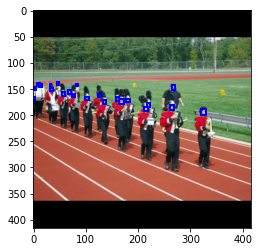

tensor([[0.3257, 0.4204, 0.0156, 0.0195]])
tensor([[0.3257, 0.4204, 0.0156, 0.0195],
        [0.3023, 0.3897, 0.0156, 0.0083],
        [0.1827, 0.3907, 0.0073, 0.0083],
        [0.0000, 0.4024, 0.0176, 0.0146],
        [0.1358, 0.3838, 0.0146, 0.0146],
        [0.0806, 0.3633, 0.0137, 0.0166],
        [0.1636, 0.3750, 0.0137, 0.0166],
        [0.6436, 0.3536, 0.0166, 0.0244],
        [0.4341, 0.4141, 0.0215, 0.0166],
        [0.1133, 0.3370, 0.0107, 0.0146],
        [0.5279, 0.4346, 0.0156, 0.0166],
        [0.0230, 0.3404, 0.0117, 0.0156],
        [0.0772, 0.3423, 0.0068, 0.0078],
        [0.0313, 0.3448, 0.0107, 0.0146],
        [0.1988, 0.3413, 0.0098, 0.0117],
        [0.0059, 0.3565, 0.0107, 0.0146],
        [0.3858, 0.4063, 0.0166, 0.0186],
        [0.3257, 0.4204, 0.0156, 0.0195],
        [0.1827, 0.3907, 0.0146, 0.0166],
        [0.2456, 0.4024, 0.0176, 0.0146],
        [0.0772, 0.3423, 0.0068, 0.0078],
        [0.0313, 0.3448, 0.0107, 0.0146],
        [0.1636, 0.3750, 0.0137, 

In [20]:
train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()
x,y = iter(train_loader_evaluation).next()
bboxes_batch = UTILS.cellvectors_to_bboxes(y, CONFIG.ANCHORS)
bboxes = UTILS.non_max_suppression(bboxes_batch[0], iou_threshold=1, threshold=0.7)
# print(bboxes_batch)
bboxes[1][3] = bboxes[1][3]/2
bboxes[2][2] = bboxes[2][2]/2
bboxes[2][3] = bboxes[2][3]/2
bboxes.append(copy.copy(bboxes[2]))
bboxes[3][0] = 0

# print(bboxes)

UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"),bboxes)

reference = torch.Tensor([bboxes[0][0:4]])
bboxes_tensor = torch.Tensor([box[0:4] for box in bboxes])
print(reference)
print(bboxes_tensor)

print(UTILS.intersection_over_union(reference,bboxes_tensor,"cxcywh"))
print(UTILS.intersection_over_union(reference,bboxes_tensor,"xywh"))

# overfitting test

In [25]:
model = YOLOv3().to(CONFIG.DEVICE)

  0%|          | 0/101 [00:00<?, ?it/s]

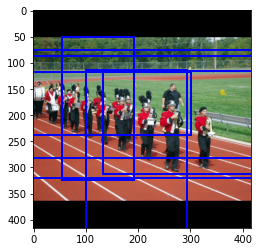

predicted boxvectors:
tensor([[ 0.4381,  0.4192,  5.2268,  1.5634,  0.4646],
        [ 0.4389,  0.5783,  3.0503,  1.5261,  0.6473],
        [ 0.3075,  0.3976,  7.3079,  1.8824,  0.5128],
        [ 0.6740,  0.5025,  6.2898,  1.6683,  0.3312],
        [ 0.4604,  0.6426,  2.0643,  1.5465,  0.6851],
        [ 0.4550,  0.6148,  4.6406,  2.5639,  0.5249],
        [ 0.6806,  0.4199,  4.8273,  2.2498,  0.6966],
        [ 0.6372,  0.5877,  8.5600,  0.7981,  0.6702],
        [ 0.4489,  0.3152,  5.8233,  2.7510,  0.7001],
        [ 0.5682,  0.3691,  2.0046,  3.9152,  0.4567],
        [ 0.3768,  0.3948,  9.7755,  0.8629,  0.6185],
        [ 0.6264,  0.4743,  2.8141,  4.4190,  0.5644],
        [ 0.5417,  0.6531,  3.7449,  5.8356,  0.4631],
        [ 0.5452,  0.5810,  9.9604,  6.2980,  0.4233],
        [ 0.6629,  0.4945, 11.8001, 10.9342,  0.1581],
        [ 0.6399,  0.4473,  7.8440, 17.0645,  0.4619],
        [ 0.6617,  0.6577,  4.1647, 22.4007,  0.4899],
        [ 0.5904,  0.4671, 14.7065, 10.0025

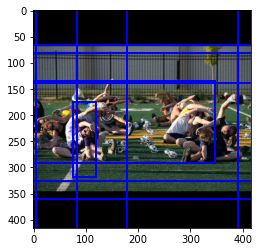

predicted boxvectors:
tensor([[ 0.5093,  0.5235,  3.5409,  5.7799,  0.5649],
        [ 0.4930,  0.5053,  3.2629,  2.6357,  0.5539],
        [ 0.6044,  0.4192,  4.1992,  2.1596,  0.3447],
        [ 0.4693,  0.6204,  6.9026,  2.7152,  0.5668],
        [ 0.3308,  0.4778,  4.8732,  2.2093,  0.5531],
        [ 0.2606,  0.5647, 11.3804,  2.1268,  0.5279],
        [ 0.4222,  0.5792,  5.5901,  4.6612,  0.4544],
        [ 0.3480,  0.4048,  4.5692,  3.7303,  0.5174],
        [ 0.6142,  0.6441,  7.2020,  6.9816,  0.4089]],
       grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439

  1%|          | 1/101 [00:00<01:30,  1.10it/s]

map: 0.0


 10%|▉         | 10/101 [00:03<00:27,  3.27it/s]

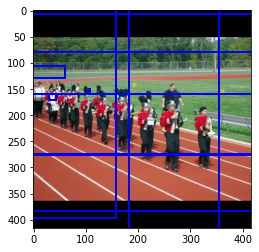

predicted boxvectors:
tensor([[0.4120, 0.4748, 0.0095, 0.0145, 0.4167],
        [0.0204, 0.0863, 0.0047, 0.0117, 0.3545],
        [0.1610, 0.8452, 0.0119, 0.0223, 0.5731],
        [0.3781, 0.6059, 0.0165, 0.0255, 0.5960],
        [0.3651, 0.0821, 0.0131, 0.0174, 0.0956],
        [0.1273, 0.2700, 0.0179, 0.0126, 0.3358],
        [0.2211, 0.4209, 0.0152, 0.0129, 0.4004],
        [0.0494, 0.2469, 0.0136, 0.0221, 0.4225],
        [0.7181, 0.8498, 0.0194, 0.0180, 0.4573],
        [0.2599, 0.7721, 0.0223, 0.0225, 0.5942],
        [0.1922, 0.0943, 0.0217, 0.0281, 0.5380],
        [0.0832, 0.6218, 0.0100, 0.0162, 0.4755],
        [0.0670, 0.7861, 0.0204, 0.0171, 0.4316],
        [0.4984, 0.5294, 0.0103, 0.0123, 0.1980],
        [0.9235, 0.0473, 0.0198, 0.0152, 0.4038],
        [0.2679, 0.5099, 0.0224, 0.0247, 0.5029],
        [0.8457, 0.6418, 0.0195, 0.0164, 0.3802],
        [0.2824, 0.4506, 0.0168, 0.0159, 0.4309],
        [0.6351, 0.4370, 0.0156, 0.0170, 0.2836],
        [0.6434, 0.4120, 0.0

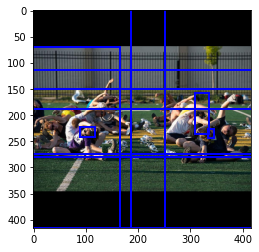

predicted boxvectors:
tensor([[0.6829, 0.9018, 0.0316, 0.0362, 0.4999],
        [0.7509, 0.4507, 0.0303, 0.0341, 0.6724],
        [0.1579, 0.8893, 0.0391, 0.0390, 0.5296],
        [0.0710, 0.1710, 0.0462, 0.0236, 0.6293],
        [0.4320, 0.6296, 0.0343, 0.0315, 0.5368],
        [0.2297, 0.2466, 0.0500, 0.0415, 0.4265],
        [0.5702, 0.3882, 0.0330, 0.0398, 0.6007],
        [0.5720, 0.1583, 0.0545, 0.0405, 0.6534],
        [0.6455, 0.2592, 0.0462, 0.0342, 0.4150]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 21.603687286376953


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


map: 0.0


 20%|█▉        | 20/101 [00:07<00:24,  3.27it/s]

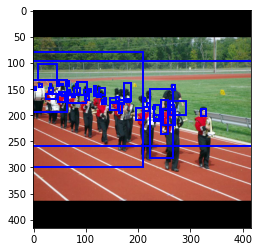

predicted boxvectors:
tensor([[0.4325, 0.4507, 0.0089, 0.0141, 0.6558],
        [0.0155, 0.6054, 0.0089, 0.0071, 0.3580],
        [0.1434, 0.8843, 0.0118, 0.0142, 0.7518],
        [0.3796, 0.6102, 0.0179, 0.0257, 0.7255],
        [0.3562, 0.0704, 0.0129, 0.0152, 0.6673],
        [0.1752, 0.1874, 0.0144, 0.0151, 0.7084],
        [0.2626, 0.3516, 0.0119, 0.0186, 0.7428],
        [0.0337, 0.2573, 0.0177, 0.0197, 0.7453],
        [0.7294, 0.8699, 0.0204, 0.0175, 0.8494],
        [0.2686, 0.8096, 0.0209, 0.0213, 0.7884],
        [0.1844, 0.0718, 0.0231, 0.0335, 0.7765],
        [0.0684, 0.6615, 0.0091, 0.0128, 0.5986],
        [0.0465, 0.6949, 0.0106, 0.0180, 0.6149],
        [0.5441, 0.4284, 0.0090, 0.0125, 0.4341],
        [0.9177, 0.0795, 0.0161, 0.0159, 0.8366],
        [0.2719, 0.4506, 0.0204, 0.0222, 0.7194],
        [0.8557, 0.6521, 0.0145, 0.0179, 0.7496],
        [0.3190, 0.4107, 0.0111, 0.0145, 0.4271],
        [0.4918, 0.4007, 0.0114, 0.0128, 0.2202],
        [0.6804, 0.4179, 0.0

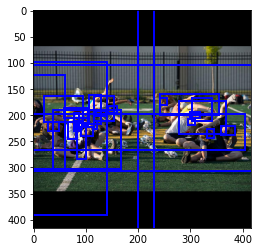

100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

predicted boxvectors:
tensor([[0.6947, 0.8976, 0.0405, 0.0361, 0.7970],
        [0.7700, 0.4376, 0.0320, 0.0294, 0.7167],
        [0.1668, 0.9056, 0.0485, 0.0362, 0.6838],
        [0.0452, 0.1637, 0.0391, 0.0275, 0.8476],
        [0.4357, 0.6800, 0.0358, 0.0298, 0.7559],
        [0.1949, 0.2551, 0.0479, 0.0401, 0.8321],
        [0.5776, 0.3494, 0.0344, 0.0457, 0.8129],
        [0.5993, 0.1674, 0.0579, 0.0413, 0.7591],
        [0.6539, 0.2399, 0.0404, 0.0325, 0.7429]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 16.539710998535156



 21%|██        | 21/101 [00:08<00:42,  1.90it/s]

map: 0.0


 30%|██▉       | 30/101 [00:10<00:21,  3.26it/s]

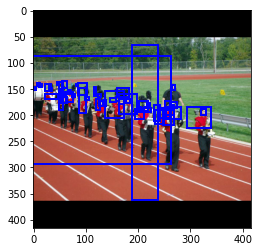

predicted boxvectors:
tensor([[0.3870, 0.5062, 0.0115, 0.0146, 0.5325],
        [0.0165, 0.4432, 0.0080, 0.0076, 0.2475],
        [0.1292, 0.8757, 0.0133, 0.0165, 0.7418],
        [0.3613, 0.5879, 0.0170, 0.0246, 0.7625],
        [0.3814, 0.0837, 0.0150, 0.0156, 0.8274],
        [0.1732, 0.2340, 0.0174, 0.0135, 0.7015],
        [0.2109, 0.4389, 0.0158, 0.0198, 0.5275],
        [0.0253, 0.2803, 0.0168, 0.0169, 0.7044],
        [0.7118, 0.8694, 0.0214, 0.0169, 0.8537],
        [0.2606, 0.7965, 0.0230, 0.0210, 0.8009],
        [0.1769, 0.0623, 0.0224, 0.0290, 0.8096],
        [0.0819, 0.6235, 0.0111, 0.0150, 0.6722],
        [0.0491, 0.7183, 0.0147, 0.0171, 0.7337],
        [0.5879, 0.4293, 0.0099, 0.0121, 0.6688],
        [0.9289, 0.0645, 0.0162, 0.0169, 0.8072],
        [0.2708, 0.4181, 0.0225, 0.0192, 0.7789],
        [0.8620, 0.6405, 0.0163, 0.0167, 0.8524],
        [0.2903, 0.4224, 0.0118, 0.0168, 0.6225],
        [0.4910, 0.3754, 0.0110, 0.0135, 0.5160],
        [0.6427, 0.3449, 0.0

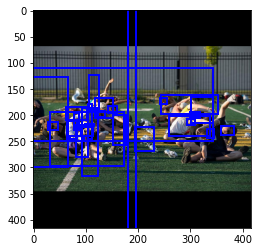

predicted boxvectors:
tensor([[0.6931, 0.9096, 0.0386, 0.0347, 0.8534],
        [0.7667, 0.4267, 0.0319, 0.0281, 0.7947],
        [0.1650, 0.9052, 0.0507, 0.0344, 0.7365],
        [0.0337, 0.1566, 0.0427, 0.0253, 0.8326],
        [0.4287, 0.6685, 0.0363, 0.0298, 0.8326],
        [0.2054, 0.2530, 0.0549, 0.0433, 0.8752],
        [0.5793, 0.3543, 0.0332, 0.0397, 0.8526],
        [0.6025, 0.1705, 0.0618, 0.0402, 0.8469],
        [0.6521, 0.2393, 0.0453, 0.0327, 0.8173]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 13.529550552368164


 31%|███       | 31/101 [00:11<00:35,  1.98it/s]

map: 0.0


 40%|███▉      | 40/101 [00:14<00:18,  3.25it/s]

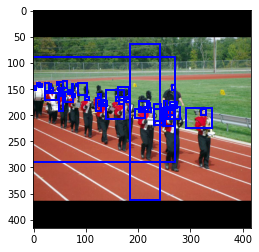

predicted boxvectors:
tensor([[0.3953, 0.4728, 0.0105, 0.0146, 0.6377],
        [0.0148, 0.4280, 0.0071, 0.0076, 0.5358],
        [0.1286, 0.8754, 0.0134, 0.0165, 0.8769],
        [0.3719, 0.6008, 0.0167, 0.0235, 0.8436],
        [0.3491, 0.0772, 0.0146, 0.0160, 0.8991],
        [0.1887, 0.2388, 0.0181, 0.0144, 0.8424],
        [0.2465, 0.4728, 0.0157, 0.0199, 0.6602],
        [0.0241, 0.2748, 0.0171, 0.0183, 0.8251],
        [0.7403, 0.8717, 0.0205, 0.0171, 0.8993],
        [0.2886, 0.8029, 0.0227, 0.0208, 0.8814],
        [0.1833, 0.0602, 0.0223, 0.0282, 0.8659],
        [0.0773, 0.6364, 0.0114, 0.0149, 0.7665],
        [0.0505, 0.7258, 0.0145, 0.0168, 0.8244],
        [0.5880, 0.4416, 0.0096, 0.0117, 0.7664],
        [0.9272, 0.0647, 0.0155, 0.0171, 0.8544],
        [0.2653, 0.4583, 0.0215, 0.0207, 0.8295],
        [0.8650, 0.6484, 0.0155, 0.0164, 0.8865],
        [0.3004, 0.4216, 0.0116, 0.0165, 0.7268],
        [0.4611, 0.3700, 0.0108, 0.0142, 0.5758],
        [0.6412, 0.3868, 0.0

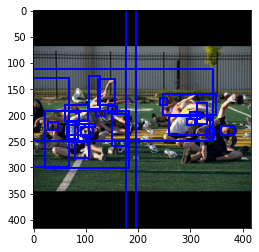

predicted boxvectors:
tensor([[0.7082, 0.9039, 0.0394, 0.0343, 0.9094],
        [0.7740, 0.4287, 0.0319, 0.0281, 0.8673],
        [0.1571, 0.9106, 0.0466, 0.0360, 0.8684],
        [0.0281, 0.1628, 0.0448, 0.0241, 0.8745],
        [0.4364, 0.6585, 0.0350, 0.0292, 0.9024],
        [0.2048, 0.2480, 0.0552, 0.0405, 0.9290],
        [0.5840, 0.3613, 0.0327, 0.0405, 0.8880],
        [0.6039, 0.1713, 0.0607, 0.0391, 0.8932],
        [0.6541, 0.2443, 0.0436, 0.0315, 0.8751]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 11.419057846069336


 41%|████      | 41/101 [00:15<00:30,  1.98it/s]

map: 0.0


 50%|████▉     | 50/101 [00:17<00:15,  3.23it/s]

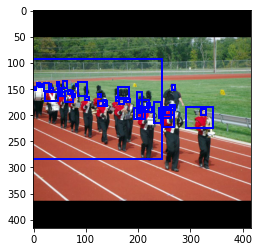

predicted boxvectors:
tensor([[0.4175, 0.4783, 0.0106, 0.0147, 0.7861],
        [0.0120, 0.4484, 0.0071, 0.0078, 0.6618],
        [0.1242, 0.8747, 0.0135, 0.0169, 0.9320],
        [0.3729, 0.5974, 0.0168, 0.0247, 0.8738],
        [0.3704, 0.0789, 0.0149, 0.0165, 0.9063],
        [0.1891, 0.2247, 0.0179, 0.0144, 0.9309],
        [0.2275, 0.4562, 0.0159, 0.0191, 0.8966],
        [0.0214, 0.2787, 0.0170, 0.0183, 0.9011],
        [0.7242, 0.8692, 0.0206, 0.0176, 0.9405],
        [0.2732, 0.7956, 0.0221, 0.0217, 0.9195],
        [0.1817, 0.0632, 0.0223, 0.0290, 0.9135],
        [0.0796, 0.6361, 0.0107, 0.0146, 0.8321],
        [0.0527, 0.7319, 0.0138, 0.0166, 0.8712],
        [0.5908, 0.4383, 0.0098, 0.0118, 0.8169],
        [0.9282, 0.0690, 0.0157, 0.0171, 0.9012],
        [0.2573, 0.4434, 0.0208, 0.0204, 0.8844],
        [0.8646, 0.6556, 0.0157, 0.0167, 0.9162],
        [0.2985, 0.4283, 0.0115, 0.0158, 0.7888],
        [0.4793, 0.3934, 0.0106, 0.0144, 0.6984],
        [0.6488, 0.3972, 0.0

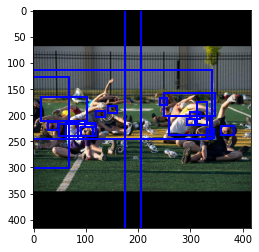

predicted boxvectors:
tensor([[0.7049, 0.9080, 0.0377, 0.0356, 0.9272],
        [0.7725, 0.4332, 0.0323, 0.0285, 0.9071],
        [0.1622, 0.9122, 0.0495, 0.0361, 0.9120],
        [0.0243, 0.1617, 0.0410, 0.0248, 0.9073],
        [0.4326, 0.6589, 0.0356, 0.0300, 0.9359],
        [0.2023, 0.2423, 0.0548, 0.0410, 0.9493],
        [0.5775, 0.3579, 0.0324, 0.0418, 0.9216],
        [0.6017, 0.1676, 0.0596, 0.0394, 0.9245],
        [0.6502, 0.2431, 0.0438, 0.0318, 0.9056]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 9.827394485473633


 50%|█████     | 51/101 [00:18<00:24,  2.01it/s]

map: 0.0


 59%|█████▉    | 60/101 [00:21<00:12,  3.26it/s]

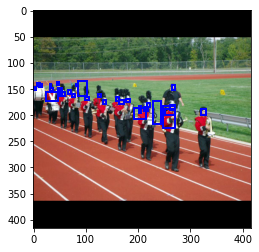

predicted boxvectors:
tensor([[0.4115, 0.4830, 0.0107, 0.0147, 0.8589],
        [0.0105, 0.4556, 0.0068, 0.0078, 0.7676],
        [0.1255, 0.8757, 0.0136, 0.0165, 0.9509],
        [0.3629, 0.5969, 0.0166, 0.0242, 0.8995],
        [0.3777, 0.0774, 0.0144, 0.0166, 0.9284],
        [0.1943, 0.2299, 0.0173, 0.0147, 0.9509],
        [0.2372, 0.4623, 0.0155, 0.0199, 0.9340],
        [0.0203, 0.2822, 0.0167, 0.0190, 0.9233],
        [0.7284, 0.8721, 0.0205, 0.0177, 0.9588],
        [0.2787, 0.7950, 0.0225, 0.0213, 0.9381],
        [0.1837, 0.0634, 0.0226, 0.0294, 0.9366],
        [0.0771, 0.6351, 0.0108, 0.0147, 0.8734],
        [0.0487, 0.7204, 0.0136, 0.0166, 0.8981],
        [0.5824, 0.4315, 0.0096, 0.0116, 0.8953],
        [0.9285, 0.0657, 0.0155, 0.0167, 0.9318],
        [0.2544, 0.4516, 0.0207, 0.0204, 0.9170],
        [0.8629, 0.6515, 0.0157, 0.0168, 0.9401],
        [0.2990, 0.4240, 0.0118, 0.0158, 0.8470],
        [0.4722, 0.3785, 0.0108, 0.0147, 0.7937],
        [0.6446, 0.3870, 0.0

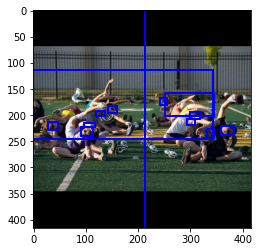

predicted boxvectors:
tensor([[0.7043, 0.9052, 0.0391, 0.0347, 0.9368],
        [0.7700, 0.4330, 0.0326, 0.0281, 0.9297],
        [0.1619, 0.9106, 0.0488, 0.0351, 0.9268],
        [0.0230, 0.1636, 0.0430, 0.0255, 0.9237],
        [0.4353, 0.6641, 0.0363, 0.0301, 0.9526],
        [0.2059, 0.2453, 0.0539, 0.0422, 0.9596],
        [0.5837, 0.3574, 0.0332, 0.0415, 0.9426],
        [0.6039, 0.1703, 0.0615, 0.0398, 0.9417],
        [0.6482, 0.2431, 0.0436, 0.0322, 0.9262]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 8.546419143676758


 60%|██████    | 61/101 [00:22<00:20,  1.93it/s]

map: 0.0


 69%|██████▉   | 70/101 [00:25<00:09,  3.24it/s]

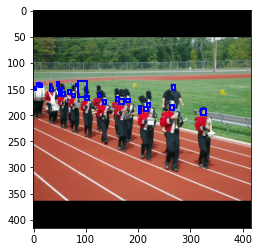

predicted boxvectors:
tensor([[0.4079, 0.4820, 0.0107, 0.0147, 0.8988],
        [0.0098, 0.4484, 0.0069, 0.0079, 0.8408],
        [0.1261, 0.8751, 0.0137, 0.0166, 0.9659],
        [0.3661, 0.5932, 0.0167, 0.0244, 0.9221],
        [0.3730, 0.0782, 0.0146, 0.0168, 0.9517],
        [0.1936, 0.2296, 0.0177, 0.0148, 0.9667],
        [0.2355, 0.4627, 0.0156, 0.0195, 0.9530],
        [0.0193, 0.2818, 0.0165, 0.0188, 0.9402],
        [0.7307, 0.8725, 0.0204, 0.0176, 0.9721],
        [0.2783, 0.7944, 0.0225, 0.0215, 0.9567],
        [0.1830, 0.0629, 0.0225, 0.0292, 0.9528],
        [0.0774, 0.6353, 0.0108, 0.0147, 0.9039],
        [0.0490, 0.7223, 0.0137, 0.0165, 0.9252],
        [0.5866, 0.4359, 0.0098, 0.0117, 0.9302],
        [0.9285, 0.0672, 0.0158, 0.0166, 0.9473],
        [0.2574, 0.4483, 0.0207, 0.0203, 0.9322],
        [0.8629, 0.6541, 0.0157, 0.0167, 0.9550],
        [0.2980, 0.4242, 0.0117, 0.0156, 0.8944],
        [0.4737, 0.3822, 0.0107, 0.0147, 0.8723],
        [0.6436, 0.3825, 0.0

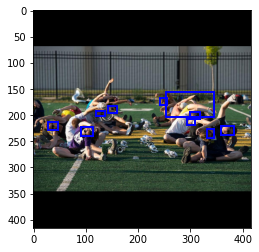

predicted boxvectors:
tensor([[0.7036, 0.9064, 0.0391, 0.0349, 0.9503],
        [0.7691, 0.4300, 0.0322, 0.0283, 0.9458],
        [0.1632, 0.9093, 0.0492, 0.0353, 0.9418],
        [0.0212, 0.1616, 0.0430, 0.0252, 0.9370],
        [0.4340, 0.6615, 0.0360, 0.0303, 0.9657],
        [0.2056, 0.2459, 0.0552, 0.0424, 0.9696],
        [0.5801, 0.3595, 0.0334, 0.0423, 0.9565],
        [0.6041, 0.1701, 0.0617, 0.0401, 0.9551],
        [0.6494, 0.2430, 0.0440, 0.0323, 0.9394]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 7.563843250274658


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


map: 0.02634071558713913


 79%|███████▉  | 80/101 [00:28<00:06,  3.24it/s]

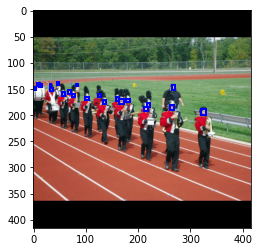

predicted boxvectors:
tensor([[0.4083, 0.4804, 0.0107, 0.0147, 0.9294],
        [0.0090, 0.4501, 0.0069, 0.0078, 0.8716],
        [0.1264, 0.8757, 0.0137, 0.0166, 0.9753],
        [0.3654, 0.5967, 0.0167, 0.0245, 0.9410],
        [0.3727, 0.0781, 0.0148, 0.0167, 0.9617],
        [0.1944, 0.2307, 0.0175, 0.0147, 0.9754],
        [0.2345, 0.4643, 0.0156, 0.0196, 0.9667],
        [0.0188, 0.2811, 0.0167, 0.0185, 0.9514],
        [0.7288, 0.8722, 0.0207, 0.0176, 0.9800],
        [0.2774, 0.7954, 0.0224, 0.0215, 0.9678],
        [0.1829, 0.0638, 0.0224, 0.0293, 0.9638],
        [0.0773, 0.6356, 0.0108, 0.0147, 0.9251],
        [0.0489, 0.7245, 0.0137, 0.0166, 0.9454],
        [0.5831, 0.4374, 0.0098, 0.0118, 0.9442],
        [0.9286, 0.0666, 0.0156, 0.0167, 0.9543],
        [0.2554, 0.4478, 0.0206, 0.0205, 0.9476],
        [0.8614, 0.6520, 0.0157, 0.0168, 0.9628],
        [0.2985, 0.4258, 0.0118, 0.0157, 0.9200],
        [0.4727, 0.3819, 0.0108, 0.0147, 0.9164],
        [0.6423, 0.3852, 0.0

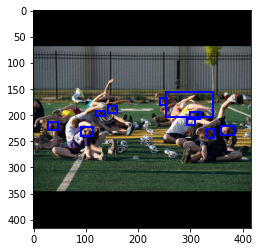

predicted boxvectors:
tensor([[0.7036, 0.9061, 0.0386, 0.0349, 0.9623],
        [0.7692, 0.4314, 0.0321, 0.0282, 0.9576],
        [0.1618, 0.9096, 0.0490, 0.0351, 0.9521],
        [0.0195, 0.1614, 0.0428, 0.0254, 0.9435],
        [0.4336, 0.6626, 0.0361, 0.0302, 0.9745],
        [0.2057, 0.2467, 0.0548, 0.0419, 0.9760],
        [0.5831, 0.3618, 0.0332, 0.0419, 0.9652],
        [0.6037, 0.1706, 0.0615, 0.0400, 0.9646],
        [0.6494, 0.2433, 0.0441, 0.0322, 0.9494]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 6.75803279876709


 80%|████████  | 81/101 [00:29<00:09,  2.01it/s]

map: 0.24155229330062866


 89%|████████▉ | 90/101 [00:32<00:03,  3.24it/s]

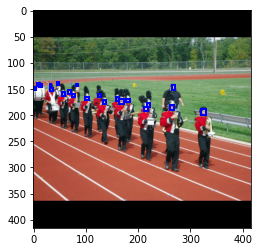

predicted boxvectors:
tensor([[0.4073, 0.4810, 0.0107, 0.0146, 0.9472],
        [0.0084, 0.4511, 0.0069, 0.0078, 0.8873],
        [0.1266, 0.8757, 0.0137, 0.0167, 0.9804],
        [0.3661, 0.5965, 0.0166, 0.0244, 0.9539],
        [0.3744, 0.0786, 0.0146, 0.0166, 0.9705],
        [0.1936, 0.2310, 0.0176, 0.0147, 0.9812],
        [0.2346, 0.4640, 0.0156, 0.0195, 0.9753],
        [0.0183, 0.2823, 0.0166, 0.0185, 0.9584],
        [0.7280, 0.8718, 0.0205, 0.0175, 0.9850],
        [0.2775, 0.7957, 0.0225, 0.0216, 0.9743],
        [0.1825, 0.0636, 0.0225, 0.0293, 0.9699],
        [0.0770, 0.6352, 0.0108, 0.0147, 0.9390],
        [0.0481, 0.7227, 0.0137, 0.0166, 0.9604],
        [0.5840, 0.4373, 0.0098, 0.0118, 0.9580],
        [0.9287, 0.0665, 0.0156, 0.0166, 0.9601],
        [0.2568, 0.4471, 0.0205, 0.0205, 0.9608],
        [0.8622, 0.6510, 0.0156, 0.0166, 0.9702],
        [0.2990, 0.4250, 0.0118, 0.0157, 0.9334],
        [0.4741, 0.3815, 0.0108, 0.0146, 0.9389],
        [0.6441, 0.3844, 0.0

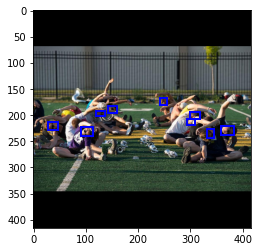

predicted boxvectors:
tensor([[0.7034, 0.9065, 0.0391, 0.0351, 0.9686],
        [0.7694, 0.4317, 0.0322, 0.0283, 0.9654],
        [0.1623, 0.9101, 0.0489, 0.0351, 0.9602],
        [0.0185, 0.1613, 0.0430, 0.0254, 0.9487],
        [0.4329, 0.6626, 0.0362, 0.0303, 0.9803],
        [0.2058, 0.2463, 0.0548, 0.0420, 0.9813],
        [0.5812, 0.3607, 0.0332, 0.0420, 0.9720],
        [0.6035, 0.1706, 0.0614, 0.0400, 0.9715],
        [0.6491, 0.2433, 0.0442, 0.0323, 0.9576]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 6.0876264572143555


 90%|█████████ | 91/101 [00:33<00:04,  2.01it/s]

map: 0.7853701114654541


 99%|█████████▉| 100/101 [00:35<00:00,  3.24it/s]

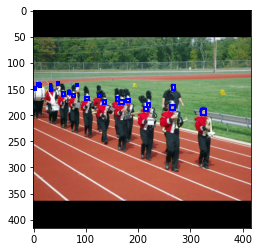

predicted boxvectors:
tensor([[0.4037, 0.4832, 0.0096, 0.0134, 0.9568],
        [0.0075, 0.4534, 0.0060, 0.0070, 0.8935],
        [0.1239, 0.8816, 0.0118, 0.0152, 0.9825],
        [0.3668, 0.5959, 0.0171, 0.0252, 0.9621],
        [0.3693, 0.0754, 0.0130, 0.0147, 0.9755],
        [0.1911, 0.2284, 0.0157, 0.0132, 0.9838],
        [0.2318, 0.4638, 0.0143, 0.0178, 0.9786],
        [0.0176, 0.2801, 0.0158, 0.0177, 0.9622],
        [0.7305, 0.8726, 0.0200, 0.0173, 0.9877],
        [0.2788, 0.7959, 0.0230, 0.0221, 0.9774],
        [0.1828, 0.0640, 0.0233, 0.0303, 0.9728],
        [0.0750, 0.6353, 0.0096, 0.0130, 0.9470],
        [0.0479, 0.7245, 0.0121, 0.0147, 0.9669],
        [0.6096, 0.4305, 0.0085, 0.0102, 0.9585],
        [0.9336, 0.0637, 0.0140, 0.0151, 0.9624],
        [0.2616, 0.4451, 0.0197, 0.0196, 0.9665],
        [0.8670, 0.6474, 0.0155, 0.0163, 0.9737],
        [0.2961, 0.4266, 0.0103, 0.0141, 0.9412],
        [0.4680, 0.3752, 0.0094, 0.0129, 0.9469],
        [0.6438, 0.3789, 0.0

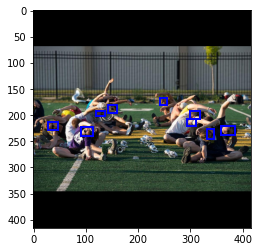

predicted boxvectors:
tensor([[0.7038, 0.9066, 0.0411, 0.0371, 0.9713],
        [0.7687, 0.4311, 0.0340, 0.0296, 0.9699],
        [0.1621, 0.9099, 0.0496, 0.0357, 0.9654],
        [0.0178, 0.1619, 0.0446, 0.0264, 0.9504],
        [0.4345, 0.6625, 0.0386, 0.0320, 0.9827],
        [0.2070, 0.2469, 0.0555, 0.0427, 0.9842],
        [0.5831, 0.3633, 0.0354, 0.0442, 0.9757],
        [0.6038, 0.1725, 0.0653, 0.0421, 0.9749],
        [0.6474, 0.2440, 0.0467, 0.0341, 0.9613]], grad_fn=<IndexBackward>)
target boxvectors:
tensor([[0.7041, 0.9073, 0.0391, 0.0351, 1.0000],
        [0.7700, 0.4314, 0.0322, 0.0283, 1.0000],
        [0.1621, 0.9101, 0.0488, 0.0351, 1.0000],
        [0.0059, 0.1612, 0.0430, 0.0254, 1.0000],
        [0.4331, 0.6626, 0.0361, 0.0303, 1.0000],
        [0.2061, 0.2464, 0.0547, 0.0420, 1.0000],
        [0.5820, 0.3606, 0.0332, 0.0420, 1.0000],
        [0.6040, 0.1702, 0.0615, 0.0400, 1.0000],
        [0.6489, 0.2437, 0.0439, 0.0322, 1.0000]])
loss: 6.397204875946045


100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


map: 0.9989067912101746


100%|██████████| 101/101 [00:36<00:00,  2.74it/s]


In [26]:
import torch
import torch.optim as optim

from tqdm import tqdm

import warnings
from IPython.display import clear_output
from sklearn.model_selection import KFold

test_lr = 1e-4
anchors = CONFIG.ANCHORS

def train_model(model, train_loader, epochs):


    optimizer = optim.Adam(
        model.parameters(), lr=test_lr, weight_decay=0
    )

    loss_fn = RescaledPositionalLoss()

    for epoch in tqdm(range(epochs)):
        for i, (x, y) in enumerate(train_loader_evaluation):

            x = x.to(CONFIG.DEVICE)

            model.train()

            optimizer.zero_grad()

            out = model(x)

            out_cpu = [output.to("cpu") for output in out]

            loss = (
                    loss_fn(out[0], y[0].to(CONFIG.DEVICE))
                    + loss_fn(out[1], y[1].to(CONFIG.DEVICE))
                    + loss_fn(out[2], y[2].to(CONFIG.DEVICE))
                )

            loss.backward()

            optimizer.step()

            if epoch % 10 == 0:

                bboxes_batch = UTILS.cellvectors_to_bboxes(out_cpu, CONFIG.ANCHORS)


                for i in range(len(x)):

                    bboxes = UTILS.non_max_suppression(bboxes_batch[i], threshold=0.7)

                    UTILS.plot_image(x[i].permute(1, 2, 0).to("cpu"), bboxes)

                    print("predicted boxvectors:")

                    print(out_cpu[0][i][loss_fn.obj_present(y[0][i])])

                    print("target boxvectors:")

                    print(y[0][i][loss_fn.obj_present(y[0][i])])

                    
                    print("loss: {}".format(loss))

                mean_ap = UTILS.evaluate_model(train_loader_evaluation, model)

                print("map: {}".format(mean_ap))


train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()
        
train_model(model, train_loader, 101)

# train method

In [86]:
model = YOLOv3().to(CONFIG.DEVICE)

if CONFIG.LOAD_MODEL and os.path.exists(CONFIG.CHECKPOINT_FILE):
    optimizer = optim.Adam(
        model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
    )

    UTILS.load_checkpoint(CONFIG.CHECKPOINT_FILE,model,optimizer,CONFIG.LEARNING_RATE)
    if CONFIG.DEVICE == "cuda":
        torch.cuda.empty_cache()

In [87]:
# If had a previous run, you can set a number of previous epochs when loadnig from a checkpoint
previousEpochs = 20

def train_model(model, train_loader, epochs):
    optimizer = optim.Adam(
        model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
    )

    loss_fn = YoloLoss()
    
    # Progress bars for epoch and batch counting
    epoch_tqdm = trange(epochs, desc="Epochs", position=0, initial=previousEpochs)
    batch_tqdm = trange(len(train_loader), desc="Batches", position=1, leave=False)

    for epoch in epoch_tqdm:
        # reset batch progress bar at the start of each epoch
        batch_tqdm.reset()
        for i, (x, y) in enumerate(train_loader):
            # update the batch progress bar
            batch_tqdm.update(1)
            
            x = x.to(CONFIG.DEVICE)

            model.train()

            optimizer.zero_grad()

            out = model(x)
            
            out_cpu = [output.to("cpu") for output in out]


            loss = (
                    loss_fn(out[0], y[0].to(CONFIG.DEVICE))
                    + loss_fn(out[1], y[1].to(CONFIG.DEVICE))
                    + loss_fn(out[2], y[2].to(CONFIG.DEVICE))
                )

            loss.backward()

            optimizer.step()

            if i % 200 == 0 and i != 0:
                
                if CONFIG.SAVE_MODEL:
                    UTILS.save_checkpoint(model, optimizer, filename=CONFIG.CHECKPOINT_FILE)
                    
                bboxes_batch = UTILS.cellvectors_to_bboxes(out_cpu, CONFIG.ANCHORS)

                bboxes = UTILS.non_max_suppression(bboxes_batch[0], threshold=0.5)

                UTILS.plot_image(x[0].permute(1, 2, 0).to("cpu"), bboxes)

                print("predicted boxvectors:")

                print(out_cpu[0][loss_fn.obj_present(y[0])])

                print("target boxvectors:")

                print(y[0][loss_fn.obj_present(y[0])])
                
                if CONFIG.DEVICE == "cuda":
                    torch.cuda.empty_cache()
        
        if CONFIG.SAVE_MODEL:
                UTILS.save_checkpoint(model, optimizer, filename=CONFIG.CHECKPOINT_FILE)
                
train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()
        
train_model(model, train_loader, CONFIG.NUM_EPOCHS)

Epochs:  20%|##        | 20/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/1288 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 4.00 GiB total capacity; 2.64 GiB already allocated; 0 bytes free; 2.68 GiB reserved in total by PyTorch)